## Set up import function

In [1]:
# Set JVM environment variable
from transcription_pipeline import preprocessing_pipeline

`JAVA_HOME` environment variable set to /home/ybadal/mambaforge/envs/transcription_pipeline


In [2]:
# Minor adjustments to dask-image code to force jpype use
# -*- coding: utf-8 -*-
import glob
import numbers
import warnings

import dask.array as da
import numpy as np
import pims
from tifffile import natural_sorted


def imread(fname, nframes=1, *, arraytype="numpy"):
    """
    Read image data into a Dask Array.

    Provides a simple, fast mechanism to ingest image data into a
    Dask Array.

    Parameters
    ----------
    fname : str or pathlib.Path
        A glob like string that may match one or multiple filenames.
        Where multiple filenames match, they are sorted using
        natural (as opposed to alphabetical) sort.
    nframes : int, optional
        Number of the frames to include in each chunk (default: 1).
    arraytype : str, optional
        Array type for dask chunks. Available options: "numpy", "cupy".

    Returns
    -------
    array : dask.array.Array
        A Dask Array representing the contents of all image files.
    """

    sfname = str(fname)
    if not isinstance(nframes, numbers.Integral):
        raise ValueError("`nframes` must be an integer.")
    if (nframes != -1) and not (nframes > 0):
        raise ValueError("`nframes` must be greater than zero.")

    if arraytype == "numpy":
        arrayfunc = np.asanyarray
    elif arraytype == "cupy":  # pragma: no cover
        import cupy

        arrayfunc = cupy.asanyarray

    with pims.open(
        sfname
    ) as imgs:  # with pims.open(sfname, read_mode="jpype") as imgs:
        shape = (len(imgs),) + imgs.frame_shape
        dtype = np.dtype(imgs.pixel_type)

    if nframes == -1:
        nframes = shape[0]

    if nframes > shape[0]:
        warnings.warn(
            "`nframes` larger than number of frames in file."
            " Will truncate to number of frames in file.",
            RuntimeWarning,
        )
    elif shape[0] % nframes != 0:
        warnings.warn(
            "`nframes` does not nicely divide number of frames in file."
            " Last chunk will contain the remainder.",
            RuntimeWarning,
        )

    # place source filenames into dask array after sorting
    filenames = natural_sorted(glob.glob(sfname))
    if len(filenames) > 1:
        ar = da.from_array(filenames, chunks=(nframes,))
        multiple_files = True
    else:
        ar = da.from_array(filenames * shape[0], chunks=(nframes,))
        multiple_files = False

    # read in data using encoded filenames
    a = ar.map_blocks(
        _map_read_frame,
        chunks=da.core.normalize_chunks((nframes,) + shape[1:], shape),
        multiple_files=multiple_files,
        new_axis=list(range(1, len(shape))),
        arrayfunc=arrayfunc,
        meta=arrayfunc([]).astype(dtype),  # meta overwrites `dtype` argument
    )
    return a


def _map_read_frame(x, multiple_files, block_info=None, **kwargs):
    fn = x[0]  # get filename from input chunk

    if multiple_files:
        i, j = 0, 1
    else:
        i, j = block_info[None]["array-location"][0]

    return _read_frame(fn=fn, i=slice(i, j), **kwargs)


def _read_frame(fn, i, *, arrayfunc=np.asanyarray):
    with pims.open(fn) as imgs:  # with pims.open(fn, read_mode="jpype") as imgs:
        return arrayfunc(imgs[i])

## Import data

In [3]:
dataset_name = "rotation1_sam_reck-peterson/actual_data/split_series/dark_27.tif"
bf = imread(dataset_name)

## Open napari for visualization

In [387]:
from importlib import reload
reload(napari)

<module 'napari' from '/home/ybadal/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/napari/__init__.py'>

In [3]:
import napari

In [4]:
viewer = napari.Viewer()

In [6]:
viewer.add_image(bf)

<Image layer 'bf' at 0x7f379419a500>

## Image analysis

In [5]:
# Start Dask client for parallelization
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(
    host="localhost",
    scheduler_port=8786,
    threads_per_worker=1,
    n_workers=12,
    memory_limit="10GB",
)

client = Client(cluster)

In [6]:
from tqdm import tqdm
import zarr

import dask.array as da
import dask_image.ndfilters
from skimage.registration import phase_cross_correlation

import trackpy as tp
import warnings


def find_hyphae_flow(
    movie,
    *,
    output_folder,
    chunk_frames=5,
    register=True,
    overlap_ratio=0.95,
    std_filter=True,
    std_filter_size=8,
    gaussian_blur=True,
    gaussian_blur_size=8,
):
    """ """
    # Register images in case stage moved
    if register:
        # Find stage shift using cross-correlation
        shift = []

        for i in tqdm(range(1, movie.shape[0]), desc="Registering frames"):
            shift.append(
                phase_cross_correlation(
                    movie[i - 1],
                    movie[i],
                    overlap_ratio=overlap_ratio,
                )[0]
            )

        shift = np.array(shift)

        # Stabilize image
        cumulative_shift = shift.cumsum(axis=0)

        negative_padding = np.min(cumulative_shift * (cumulative_shift < 0), axis=0)
        positive_padding = np.max(cumulative_shift * (cumulative_shift > 0), axis=0)

        cropped_shape = (
            movie.shape[0],
            *(np.array(movie.shape[1:]) - (positive_padding - negative_padding)),
        )

        cropped_image = da.zeros(cropped_shape, dtype=movie.dtype)

        # Find shift required for t=0
        cropped_image[0] = movie[
            0,
            positive_padding[0] : movie.shape[1] + negative_padding[0],
            positive_padding[1] : movie.shape[2] + negative_padding[1],
        ]

        # Shift subsequent frames
        for i in range(1, movie.shape[0]):
            cropped_image[i] = movie[
                i,
                positive_padding[0]
                - cumulative_shift[i - 1, 0] : positive_padding[0]
                - cumulative_shift[i - 1, 0]
                + cropped_image.shape[1],
                positive_padding[1]
                - cumulative_shift[i - 1, 1] : positive_padding[1]
                - cumulative_shift[i - 1, 1]
                + cropped_image.shape[2],
            ]

        # Swap stabilized movie for next steps
        movie = cropped_image
        stabilized_zarr_store = zarr.DirectoryStore(
            output_folder + "/stabilized_movie.zarr"
        )
        stabilized_zarr = movie.to_zarr(
            stabilized_zarr_store,
            overwrite=True,
        )

    # Take standard deviation filter to get consistent contrast in brightfield images
    if std_filter:
        spatial_stdev = da.zeros_like(cropped_image)

        for i in range(cropped_image.shape[0]):
            spatial_stdev[i] = dask_image.ndfilters.generic_filter(
                cropped_image[i], np.std, size=std_filter_size
            )

        # Swap std-filtered movie for next steps
        movie = spatial_stdev

    if gaussian_blur:
        blurred_movie = da.zeros_like(movie)

        for i in range(movie.shape[0]):
            blurred_movie[i] = dask_image.ndfilters.gaussian_filter(
                movie[i],
                gaussian_blur_size,
            )

        # Swap blurred movie for next steps
        movie = blurred_movie

    # Take frame-by-frame difference along movie to find flow
    successive_differences = da.zeros_like(movie, dtype=int)

    successive_differences[:] = movie
    successive_differences[1:] = (
        successive_differences[1:] - successive_differences[:-1]
    )
    successive_differences[0] = 0

    successive_differences_zarr_store = zarr.DirectoryStore(
        output_folder + "/frame_differenced_movie.zarr"
    )
    successive_differences_zarr = successive_differences.to_zarr(
        successive_differences_zarr_store,
        overwrite=True,
    )

    return stabilized_zarr, successive_differences_zarr


def locate_and_track_flow(
    optical_flow_movie,
    *,
    subtract_mean=True,
    feature_diameter=41,
    threshold_feature="mass",
    threshold=10000,
    pos_columns=["y", "x"],
    initial_predictor=None,
    initial_search_range=10,
    initial_memory=0,
    min_track_length=4,
    final_predictor="velocity",
    final_search_range=30,
    final_memory=3,
):
    tqdm.write("Mean subtraction")
    if subtract_mean:
        flow_movie = (
            optical_flow_movie - da.mean(optical_flow_movie, axis=0)
        ).compute()
    else:
        flow_movie = optical_flow_movie

    tqdm.write("Locating optical flow peaks")
    locate_peaks = tp.batch(flow_movie, diameter=feature_diameter, processes=1)

    thresholded_peaks = locate_peaks[locate_peaks[threshold_feature] > threshold]

    # Switch either to standard Crocker-Grier or velocity predictor for preliminary
    # tracking.
    if initial_predictor == "velocity":
        velocity_predictor = tp.predict.NearestVelocityPredict()
        link_df = velocity_predictor.link_df
    elif initial_predictor is None:
        link_df = tp.link_df

    tqdm.write("Tracking hyphae tips")
    # Initial tracking
    try:
        tracked_df = link_df(
            thresholded_peaks,
            pos_columns=pos_columns,
            search_range=initial_search_range,
            memory=initial_memory,
        )
    except tp.SubnetOversizeException:
        warnings.warn("Failed initial tracking, returning untracked detected features.")
        return tracked_df

    tqdm.write("Filtering stubs")
    # Filter out stubs
    track_length = tracked_df.apply(
        lambda x: (tracked_df["particle"] == x["particle"]).sum(),
        axis=1,
    )

    filtered_tracks = tracked_df[track_length > min_track_length]

    tqdm.write("Re-tracking hyphae post-filtering")
    # Do a second tracking after the filtering step
    if final_predictor == "velocity":
        final_velocity_predictor = tp.predict.NearestVelocityPredict()
        final_link_df = final_velocity_predictor.link_df
    elif final_predictor is None:
        final_link_df = tp.link_df

    try:
        retracked_df = final_link_df(
            filtered_tracks.copy(),
            pos_columns=pos_columns,
            search_range=final_search_range,
            memory=final_memory,
        )
    except tp.SubnetOversizeException:
        warnings.warn("Failed final tracking, returning filtered initial tracking.")
        return filtered_tracks

    return retracked_df

In [7]:
dataset_list = [
    "rotation1_sam_reck-peterson/actual_data/split_series/dark_27.tif",
    "rotation1_sam_reck-peterson/actual_data/split_series/dark_32.tif",
    "rotation1_sam_reck-peterson/actual_data/split_series/dark_36.tif",
    "rotation1_sam_reck-peterson/actual_data/split_series/light_27.tif",
    "rotation1_sam_reck-peterson/actual_data/split_series/light_32.tif",
    "rotation1_sam_reck-peterson/actual_data/split_series/light_36.tif",
]

dataset_output_folders = [
    "rotation1_sam_reck-peterson/actual_data/split_series/dark_27_processed",
    "rotation1_sam_reck-peterson/actual_data/split_series/dark_32_processed",
    "rotation1_sam_reck-peterson/actual_data/split_series/dark_36_processed",
    "rotation1_sam_reck-peterson/actual_data/split_series/light_27_processed",
    "rotation1_sam_reck-peterson/actual_data/split_series/light_32_processed",
    "rotation1_sam_reck-peterson/actual_data/split_series/light_36_processed",
]

In [95]:
for i, dataset_name in enumerate(dataset_list):
    bf = imread(dataset_name)

    stabilized_bf, diff_bf = find_hyphae_flow(
        bf,
        output_folder=dataset_output_folders[i],
        chunk_frames=5,
        register=True,
        overlap_ratio=0.95,
        std_filter=True,
        std_filter_size=3,
        gaussian_blur=True,
        gaussian_blur_size=2,
    )

Registering frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.64it/s]


In [21]:
# stabilized_bf, diff_bf = find_hyphae_flow(
#     bf,
#     output_folder="rotation1_sam_reck-peterson/sam-groupA_wf/test_experiment_processing",
#     chunk_frames=5,
#     register=True,
#     overlap_ratio=0.95,
#     std_filter=True,
#     std_filter_size=3,
#     gaussian_blur=True,
#     gaussian_blur_size=2,
# )

Registering frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.59it/s]


In [22]:
# stabilized_bf = zarr.open(
#     "rotation1_sam_reck-peterson/sam-groupA_wf/test_experiment_processing/stabilized_movie.zarr"
# )
# diff_bf = zarr.open(
#     "rotation1_sam_reck-peterson/sam-groupA_wf/test_experiment_processing/frame_differenced_movie.zarr"
# )

In [8]:
i = 5

stabilized_bf = zarr.open(dataset_output_folders[i] + "/stabilized_movie.zarr")
diff_bf = zarr.open(dataset_output_folders[i] + "/frame_differenced_movie.zarr")

In [14]:
dataset = "rotation1_sam_reck-peterson/sam-groupA_wf/test_experiment_processing"
stabilized_bf = zarr.open(dataset + "/stabilized_movie.zarr")
diff_bf = zarr.open(dataset + "/frame_differenced_movie.zarr")

In [15]:
%%time

retracked_df = locate_and_track_flow(
    diff_bf,
    subtract_mean=True,
    feature_diameter=11,
    threshold_feature="mass",
    threshold=800,
    pos_columns=["y", "x"],
    initial_predictor=None,
    initial_search_range=5,
    initial_memory=0,
    min_track_length=4,
    final_predictor="velocity",
    final_search_range=15,
    final_memory=3,
)

Frame 50: 90 trajectories present.
CPU times: user 31.6 s, sys: 1.19 s, total: 32.8 s
Wall time: 32.2 s


In [16]:
bf_layer = viewer.add_image(stabilized_bf[:])

In [17]:
diff_layer = viewer.add_image(diff_bf[:])

In [12]:
peak_coords = retracked_df[["frame", "y", "x"]].values
point_ids = {"id": retracked_df["particle"].values}

In [13]:
tracked_points = viewer.add_points(
    peak_coords,
    size=10,
    properties=point_ids,
    face_color="id",
    face_colormap="hsv",
)

Rendering frames...


100%|████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 37.93it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 36.34it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.37it/s]


Rendering frames...


  0%|                                                                 | 0/16 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1364, 1077) to (1376, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x55598d319e00] Stream #0: not enough frames to estimate rate; consider increasing probesize
100%|████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 30.14it/s]


Rendering frames...


100%|████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 28.16it/s]


Rendering frames...


100%|████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 26.01it/s]


Rendering frames...


100%|████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 26.70it/s]


Rendering frames...


100%|████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.44it/s]


Rendering frames...


  0%|                                                                 | 0/16 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1364, 1077) to (1376, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x5625a283be00] Stream #0: not enough frames to estimate rate; consider increasing probesize
100%|████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.60it/s]


Rendering frames...


  0%|                                                                 | 0/16 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1364, 1077) to (1376, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x55734491ce00] Stream #0: not enough frames to estimate rate; consider increasing probesize
100%|████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 25.86it/s]


Rendering frames...


  0%|                                                                 | 0/16 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1364, 1077) to (1376, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x5636312a6e00] Stream #0: not enough frames to estimate rate; consider increasing probesize
100%|████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 30.27it/s]


## Summary statistics

In [18]:
import numpy as np
import trackpy as tp
import matplotlib.pyplot as plt
import pims
import pandas as pd

In [19]:
dataset_name = "rotation1_sam_reck-peterson/sam-groupA_wf/Experiment.nd2"

dataset_bioformats = pims.Bioformats(dataset_name)  # , read_mode="jpype")

/home/ybadal/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '


In [22]:
mppYX = dataset_bioformats.metadata.PixelsPhysicalSizeX(0) # * 10**4
fph = 12  # Frames per hour (every 5 minutes)

In [23]:
mppYX

0.325

### Ballistic-diffusion transition

In [24]:
msd = tp.motion.emsd(retracked_df, mppYX, fph)

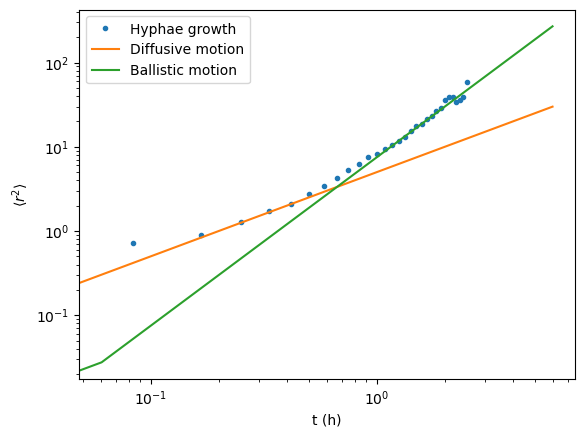

In [40]:
plt.plot(msd, ".", label="Hyphae growth")
plt.xlabel("t (h)")
plt.ylabel(r"$\langle r^2 \rangle $")

t = np.linspace(0, 6, 100)
# msd_diff = 310 * t**2
msd_ball = 7.5 * t**2
msd_diff = 5*t
plt.plot(t, msd_diff, label="Diffusive motion")
plt.plot(t, msd_ball, label="Ballistic motion")
plt.yscale("log")
plt.xscale("log")

plt.legend()

plt.show()

In [286]:
tracks_layer = viewer.add_tracks(
    retracked_df_vel[["particle", "frame", "y", "x"]].values,
    properties={"v": retracked_df_vel["v"].values},
    color_by="v",
)

/home/ybadal/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/napari/layers/tracks/tracks.py:623: UserWarning: Previous color_by key 'v' not present in features. Falling back to track_id
  warn(


### Angular diffusion

In [280]:
def add_velocity(tracked_df, pos_columns=["y", "x"], vel_averaging_window=4):
    """ """
    tracked_dataframe = tracked_df.copy()
    # Sort by frame
    tracked_dataframe = tracked_dataframe.sort_values("frame")

    # List out tracks
    tracks = tracked_dataframe["particle"].unique()
    vel_columns = ["".join(["v_", pos]) for pos in pos_columns]

    for track in tracks:
        # Add velocity vectors to all tracks
        vel_vectors = (
            tracked_dataframe.loc[tracked_dataframe["particle"] == track, pos_columns][
                1:
            ].values
            - tracked_dataframe.loc[
                tracked_dataframe["particle"] == track, pos_columns
            ][:-1].values
        )
        vel_vectors = pd.DataFrame(
            np.vstack([np.array([0] * len(vel_columns)), vel_vectors])
        )
        # Take rolling mean if needed
        if vel_averaging_window > 1:
            vel_vectors = (
                vel_vectors.rolling(vel_averaging_window, min_periods=0).mean().values
            )

        tracked_dataframe.loc[
            tracked_dataframe["particle"] == track, vel_columns
        ] = vel_vectors

        tracked_dataframe.loc[tracked_dataframe["particle"] == track, "v"] = np.sqrt(
            (vel_vectors**2).sum(axis=1)
        )

        # Add angle of velocity to initial angle
        vel_vectors = vel_vectors[1:]
        norm_vectors = vel_vectors / np.repeat(
            np.sqrt((vel_vectors**2).sum(axis=1))[:, np.newaxis], 2, axis=1
        )
        try:
            init_vel = norm_vectors[0]
            angle_with_init = np.arccos((init_vel * norm_vectors).sum(axis=1)[1:])
            angle_with_init = np.insert(angle_with_init, 0, [0.0, 0.0])

            tracked_dataframe.loc[
                tracked_dataframe["particle"] == track, "vel_angle_with_initial"
            ] = angle_with_init
        except IndexError:
            tracked_dataframe.loc[
                tracked_dataframe["particle"] == track, "vel_angle_with_initial"
            ] = np.nan

    return tracked_dataframe


def msad(tracked_vel_df, mpp, fph):
    """ """
    tracked_dataframe = tracked_vel_df.copy()
    # Sort by frame
    tracked_dataframe = tracked_dataframe.sort_values("frame")
    frames = np.arange(tracked_dataframe["frame"].max())

    # List out tracks
    tracks = tracked_dataframe["particle"].unique()
    num_tracks = tracks.shape[0]
    track_angles = np.zeros((num_tracks, frames.size), dtype=float)
    track_angles[:] = np.nan

    for i, track in enumerate(tracks):
        track_mask = tracked_dataframe["particle"] == track
        track_length = track_mask.sum()
        track_angles[i, :track_length] = tracked_dataframe.loc[
            track_mask, "vel_angle_with_initial"
        ]

    msad_vector = np.nanmean(track_angles**2, axis=0)
    time = frames / fph

    return pd.Series(data=msad_vector, index=time, name="lagt")

In [281]:
retracked_df

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
185,159.368387,243.818871,1450.725650,2.792877,0.222800,47.733554,-2011.156863,0.922256,0,0
261,232.624090,321.059010,1253.005783,2.666912,0.223210,46.563614,2000.313725,0.204690,0,1
287,258.312175,182.004378,855.226170,2.755668,0.104494,28.780525,-469.019608,0.392838,0,2
307,275.301255,309.756237,1509.924616,2.966704,0.132033,41.883853,2771.705882,0.178050,0,3
309,276.567188,593.866098,1481.846055,2.857365,0.150749,45.159686,2413.392157,0.189507,0,4
...,...,...,...,...,...,...,...,...,...,...
133760,315.540388,622.325611,5770.424645,3.053479,0.181493,148.144903,19270.215686,0.078012,50,352
133801,333.177160,333.740849,4935.754581,3.006825,0.236724,137.305032,16623.000000,0.086118,50,414
133785,328.967309,868.762364,8621.310710,2.661151,0.134443,310.742968,19565.647059,0.077201,50,658
133788,328.923860,170.384578,7450.604646,2.717726,0.221023,270.996774,19130.352941,0.078402,50,308


In [282]:
retracked_df_vel = add_velocity(retracked_df, vel_averaging_window=4)

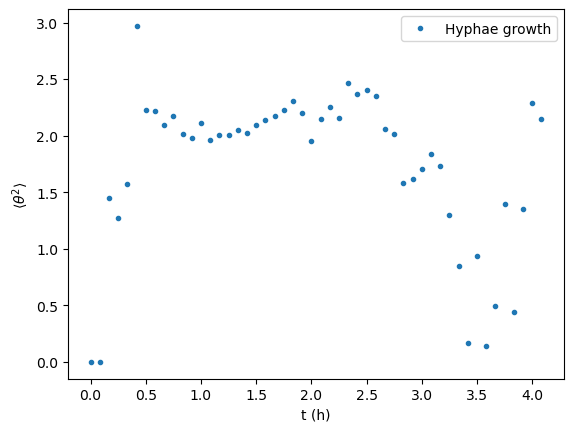

In [283]:
plt.plot(msad(retracked_df_vel, mppYX, fph), ".", label="Hyphae growth")
plt.xlabel("t (h)")
plt.ylabel(r"$\langle \theta^2 \rangle $")
# plt.yscale("log")

t = np.linspace(0, 6, 100)

plt.legend()

plt.show()

## Velocities across hyphae

In [284]:
dataset_output_folders[i]

'rotation1_sam_reck-peterson/actual_data/split_series/light_36_processed'

In [150]:
# tracked_df_dark_27 = retracked_df_vel.copy()

In [198]:
# tracked_df_dark_32 = retracked_df_vel.copy()

In [218]:
# tracked_df_dark_36 = retracked_df_vel.copy()

In [247]:
# tracked_df_light_27 = retracked_df_vel.copy()

In [267]:
# tracked_df_light_32 = retracked_df_vel.copy()

In [285]:
# tracked_df_light_36 = retracked_df_vel.copy()

#### Light vs dark

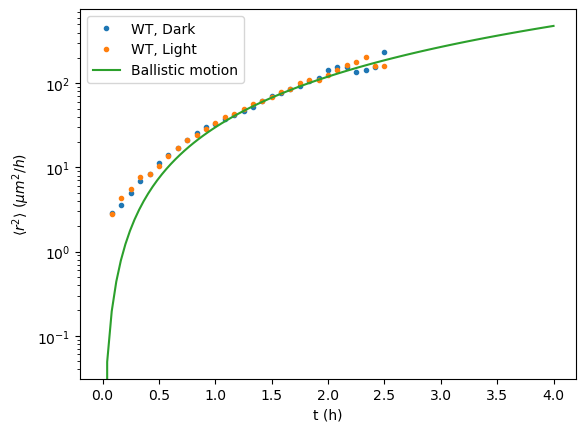

In [401]:
msd_dark_27 = tp.motion.emsd(tracked_df_dark_27, mppYX, fph)
msd_light_27 = tp.motion.emsd(tracked_df_light_27, mppYX, fph)

plt.plot(msd_dark_27, ".", label="WT, Dark")
plt.plot(msd_light_27, ".", label="WT, Light")
plt.xlabel("t (h)")
plt.ylabel(r"$\langle r^2 \rangle \ (\mu m^2/h)$")
plt.yscale("log")

t = np.linspace(0, 4, 100)
# msd_diff = 310 * t**2
msd_diff = 30 * t**2
plt.plot(t, msd_diff, label="Ballistic motion")

plt.legend()

plt.show()

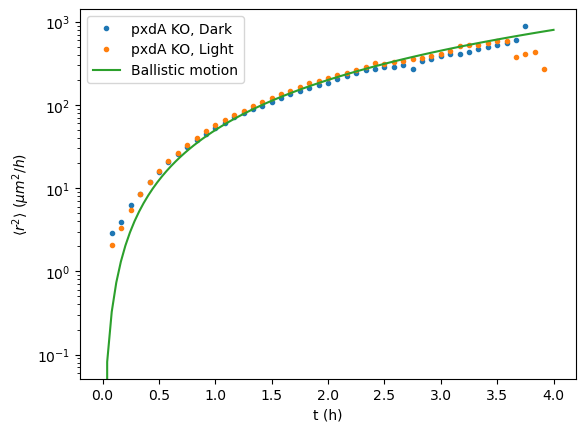

In [402]:
msd_dark_32 = tp.motion.emsd(tracked_df_dark_32, mppYX, fph)
msd_light_32 = tp.motion.emsd(tracked_df_light_32, mppYX, fph)

plt.plot(msd_dark_32, ".", label="pxdA KO, Dark")
plt.plot(msd_light_32, ".", label="pxdA KO, Light")
plt.xlabel("t (h)")
plt.ylabel(r"$\langle r^2 \rangle \ (\mu m^2/h)$")
plt.yscale("log")

t = np.linspace(0, 4, 100)
# msd_diff = 310 * t**2
msd_diff = 50 * t**2
plt.plot(t, msd_diff, label="Ballistic motion")

plt.legend()

plt.show()

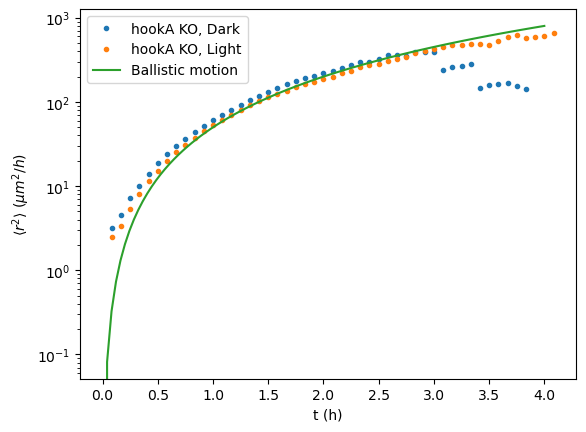

In [403]:
msd_dark_36 = tp.motion.emsd(tracked_df_dark_36, mppYX, fph)
msd_light_36 = tp.motion.emsd(tracked_df_light_36, mppYX, fph)

plt.plot(msd_dark_36, ".", label="hookA KO, Dark")
plt.plot(msd_light_36, ".", label="hookA KO, Light")
plt.xlabel("t (h)")
plt.ylabel(r"$\langle r^2 \rangle \ (\mu m^2/h)$")
plt.yscale("log")

t = np.linspace(0, 4, 100)
# msd_diff = 310 * t**2
msd_diff = 50 * t**2
plt.plot(t, msd_diff, label="Ballistic motion")

plt.legend()

plt.show()

#### KO vs WT

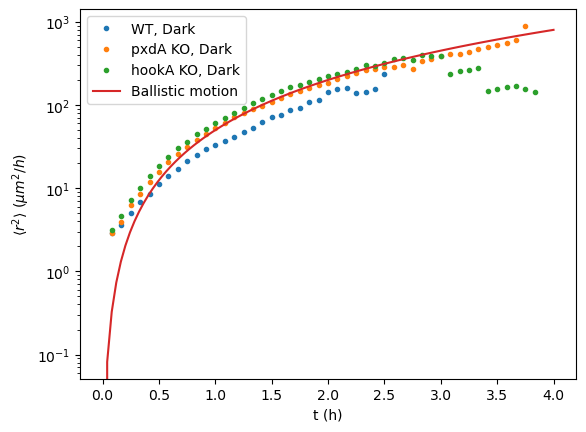

In [404]:
msd_dark_27 = tp.motion.emsd(tracked_df_dark_27, mppYX, fph)
msd_dark_32 = tp.motion.emsd(tracked_df_dark_32, mppYX, fph)
msd_dark_36 = tp.motion.emsd(tracked_df_dark_36, mppYX, fph)

plt.plot(msd_dark_27, ".", label="WT, Dark")
plt.plot(msd_dark_32, ".", label="pxdA KO, Dark")
plt.plot(msd_dark_36, ".", label="hookA KO, Dark")
plt.xlabel("t (h)")
plt.ylabel(r"$\langle r^2 \rangle \ (\mu m^2/h)$")
plt.yscale("log")

t = np.linspace(0, 4, 100)
# msd_diff = 310 * t**2
msd_diff = 50 * t**2
plt.plot(t, msd_diff, label="Ballistic motion")

plt.legend()

plt.show()

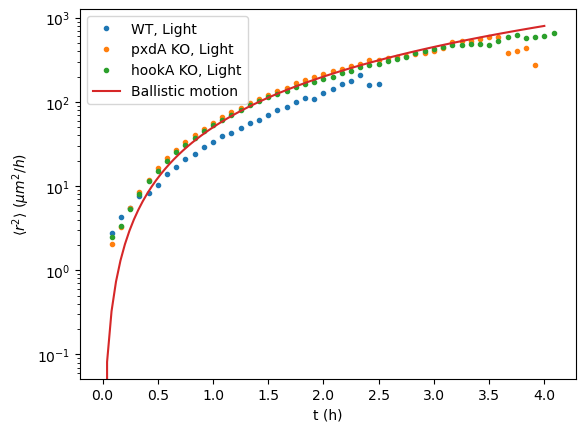

In [405]:
msd_light_27 = tp.motion.emsd(tracked_df_light_27, mppYX, fph)
msd_light_32 = tp.motion.emsd(tracked_df_light_32, mppYX, fph)
msd_light_36 = tp.motion.emsd(tracked_df_light_36, mppYX, fph)

plt.plot(msd_light_27, ".", label="WT, Light")
plt.plot(msd_light_32, ".", label="pxdA KO, Light")
plt.plot(msd_light_36, ".", label="hookA KO, Light")
plt.xlabel("t (h)")
plt.ylabel(r"$\langle r^2 \rangle \ (\mu m^2/h)$")
plt.yscale("log")

t = np.linspace(0, 4, 100)
# msd_diff = 310 * t**2
msd_diff = 50 * t**2
plt.plot(t, msd_diff, label="Ballistic motion")

plt.legend()

plt.show()

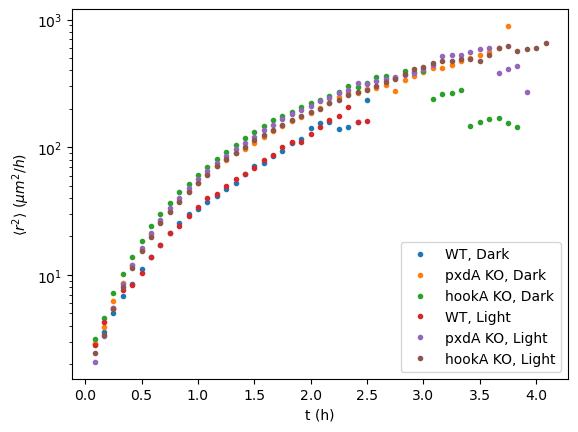

In [406]:
msd_dark_27 = tp.motion.emsd(tracked_df_dark_27, mppYX, fph)
msd_dark_32 = tp.motion.emsd(tracked_df_dark_32, mppYX, fph)
msd_dark_36 = tp.motion.emsd(tracked_df_dark_36, mppYX, fph)
msd_light_27 = tp.motion.emsd(tracked_df_light_27, mppYX, fph)
msd_light_32 = tp.motion.emsd(tracked_df_light_32, mppYX, fph)
msd_light_36 = tp.motion.emsd(tracked_df_light_36, mppYX, fph)

plt.plot(msd_dark_27, ".", label="WT, Dark")
plt.plot(msd_dark_32, ".", label="pxdA KO, Dark")
plt.plot(msd_dark_36, ".", label="hookA KO, Dark")
plt.plot(msd_light_27, ".", label="WT, Light")
plt.plot(msd_light_32, ".", label="pxdA KO, Light")
plt.plot(msd_light_36, ".", label="hookA KO, Light")

plt.xlabel("t (h)")
plt.ylabel(r"$\langle r^2 \rangle \ (\mu m^2/h)$")
plt.yscale("log")

t = np.linspace(0, 4, 100)
# msd_diff = 310 * t**2
# msd_diff =  50 * t**2
# plt.plot(t, msd_diff, label="Ballistic motion")

plt.legend()

plt.show()

#### Heterogeneity of velocities

In [332]:
# Distribution of velocities per hyphae vs std dev of average
def vel_std_dev(tracked_vel_df, mpp, fph, pos_columns=["y", "x"], frames=(0, 50)):
    tracked_dataframe = tracked_vel_df.copy()
    # Sort by frame
    tracked_dataframe = tracked_dataframe[
        (tracked_dataframe["frame"] >= frames[0])
        & (tracked_dataframe["frame"] < frames[1])
    ]
    tracked_dataframe = tracked_dataframe.sort_values("frame")

    # List out tracks
    tracks = tracked_dataframe["particle"].unique()

    # Get standard deviation of mean across hyphae
    hyphae_mean_vels = []
    hyphae_stdev_vels = []
    for track in tracks:
        track_mean_vel = np.nanmean(
            tracked_dataframe.loc[tracked_dataframe["particle"] == track, "v"]
        )
        hyphae_mean_vels.append(track_mean_vel)
        track_std_vel = np.nanstd(
            tracked_dataframe.loc[tracked_dataframe["particle"] == track, "v"]
        )
        hyphae_stdev_vels.append(track_std_vel)

    intra_hyphae_std = np.nanmean(np.array(hyphae_stdev_vels)) * mpp * fph
    inter_hyphae_std = np.nanstd(np.array(hyphae_mean_vels)) * mpp * fph

    return intra_hyphae_std, inter_hyphae_std

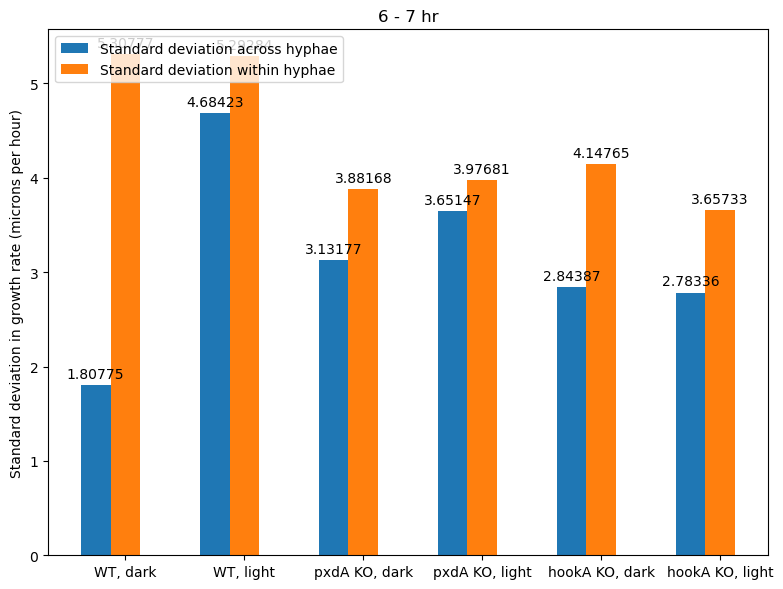

In [339]:
frame_clip = (0, 12)

intra_variation_dark_27, inter_variation_dark_27 = vel_std_dev(
    tracked_df_dark_27,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_dark_32, inter_variation_dark_32 = vel_std_dev(
    tracked_df_dark_32,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_dark_36, inter_variation_dark_36 = vel_std_dev(
    tracked_df_dark_36,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_light_27, inter_variation_light_27 = vel_std_dev(
    tracked_df_light_27,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_light_32, inter_variation_light_32 = vel_std_dev(
    tracked_df_light_32,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_light_36, inter_variation_light_36 = vel_std_dev(
    tracked_df_light_36,
    mppYX,
    fph,
    frames=frame_clip,
)

constructs = (
    "WT, dark",
    "WT, light",
    "pxdA KO, dark",
    "pxdA KO, light",
    "hookA KO, dark",
    "hookA KO, light",
)

variation = {
    "Standard deviation across hyphae": (
        inter_variation_dark_27,
        inter_variation_light_27,
        inter_variation_dark_32,
        inter_variation_light_32,
        inter_variation_dark_36,
        inter_variation_light_36,
    ),
    "Standard deviation within hyphae": (
        intra_variation_dark_27,
        intra_variation_light_27,
        intra_variation_dark_32,
        intra_variation_light_32,
        intra_variation_dark_36,
        intra_variation_light_36,
    ),
}

x = np.arange(6)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="tight", figsize=(8, 6))  # layout="constrained"

for attribute, measurement in variation.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Standard deviation in growth rate (microns per hour)")
ax.set_title("6 - 7 hr")
ax.set_xticks(x + width, constructs)
ax.legend(loc="upper left", ncols=1)
# ax.set_ylim(0, 250)

plt.show()

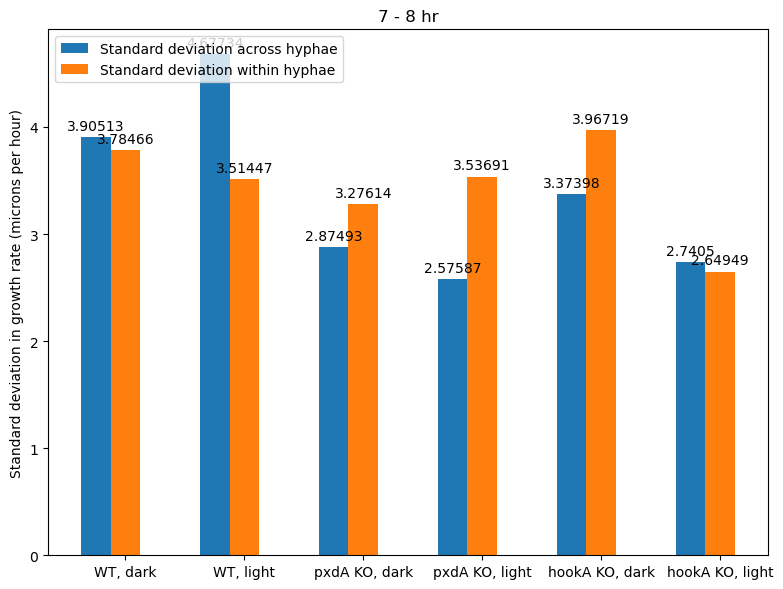

In [340]:
frame_clip = (12, 24)

intra_variation_dark_27, inter_variation_dark_27 = vel_std_dev(
    tracked_df_dark_27,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_dark_32, inter_variation_dark_32 = vel_std_dev(
    tracked_df_dark_32,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_dark_36, inter_variation_dark_36 = vel_std_dev(
    tracked_df_dark_36,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_light_27, inter_variation_light_27 = vel_std_dev(
    tracked_df_light_27,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_light_32, inter_variation_light_32 = vel_std_dev(
    tracked_df_light_32,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_light_36, inter_variation_light_36 = vel_std_dev(
    tracked_df_light_36,
    mppYX,
    fph,
    frames=frame_clip,
)

constructs = (
    "WT, dark",
    "WT, light",
    "pxdA KO, dark",
    "pxdA KO, light",
    "hookA KO, dark",
    "hookA KO, light",
)

variation = {
    "Standard deviation across hyphae": (
        inter_variation_dark_27,
        inter_variation_light_27,
        inter_variation_dark_32,
        inter_variation_light_32,
        inter_variation_dark_36,
        inter_variation_light_36,
    ),
    "Standard deviation within hyphae": (
        intra_variation_dark_27,
        intra_variation_light_27,
        intra_variation_dark_32,
        intra_variation_light_32,
        intra_variation_dark_36,
        intra_variation_light_36,
    ),
}

x = np.arange(6)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="tight", figsize=(8, 6))  # layout="constrained"

for attribute, measurement in variation.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Standard deviation in growth rate (microns per hour)")
ax.set_title("7 - 8 hr")
ax.set_xticks(x + width, constructs)
ax.legend(loc="upper left", ncols=1)
# ax.set_ylim(0, 250)

plt.show()

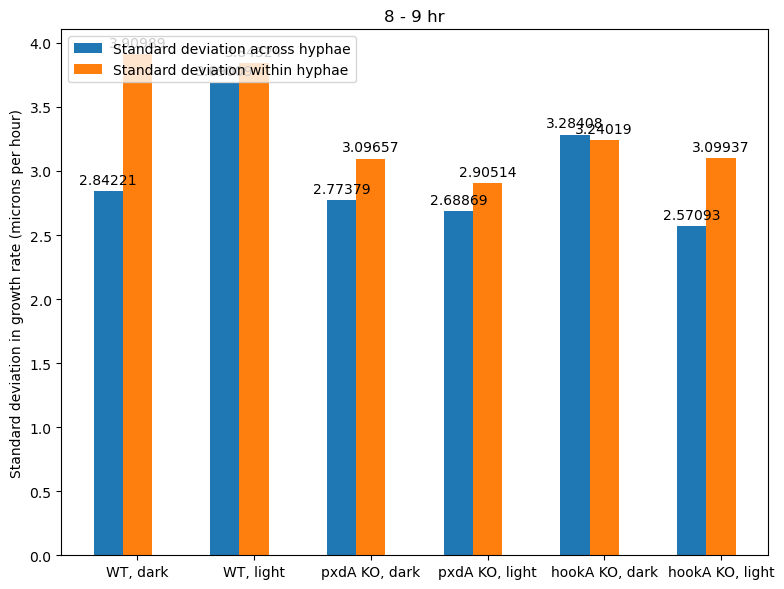

In [341]:
frame_clip = (24, 36)

intra_variation_dark_27, inter_variation_dark_27 = vel_std_dev(
    tracked_df_dark_27,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_dark_32, inter_variation_dark_32 = vel_std_dev(
    tracked_df_dark_32,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_dark_36, inter_variation_dark_36 = vel_std_dev(
    tracked_df_dark_36,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_light_27, inter_variation_light_27 = vel_std_dev(
    tracked_df_light_27,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_light_32, inter_variation_light_32 = vel_std_dev(
    tracked_df_light_32,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_light_36, inter_variation_light_36 = vel_std_dev(
    tracked_df_light_36,
    mppYX,
    fph,
    frames=frame_clip,
)

constructs = (
    "WT, dark",
    "WT, light",
    "pxdA KO, dark",
    "pxdA KO, light",
    "hookA KO, dark",
    "hookA KO, light",
)

variation = {
    "Standard deviation across hyphae": (
        inter_variation_dark_27,
        inter_variation_light_27,
        inter_variation_dark_32,
        inter_variation_light_32,
        inter_variation_dark_36,
        inter_variation_light_36,
    ),
    "Standard deviation within hyphae": (
        intra_variation_dark_27,
        intra_variation_light_27,
        intra_variation_dark_32,
        intra_variation_light_32,
        intra_variation_dark_36,
        intra_variation_light_36,
    ),
}

x = np.arange(6)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="tight", figsize=(8, 6))  # layout="constrained"

for attribute, measurement in variation.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Standard deviation in growth rate (microns per hour)")
ax.set_title("8 - 9 hr")
ax.set_xticks(x + width, constructs)
ax.legend(loc="upper left", ncols=1)
# ax.set_ylim(0, 250)

plt.show()

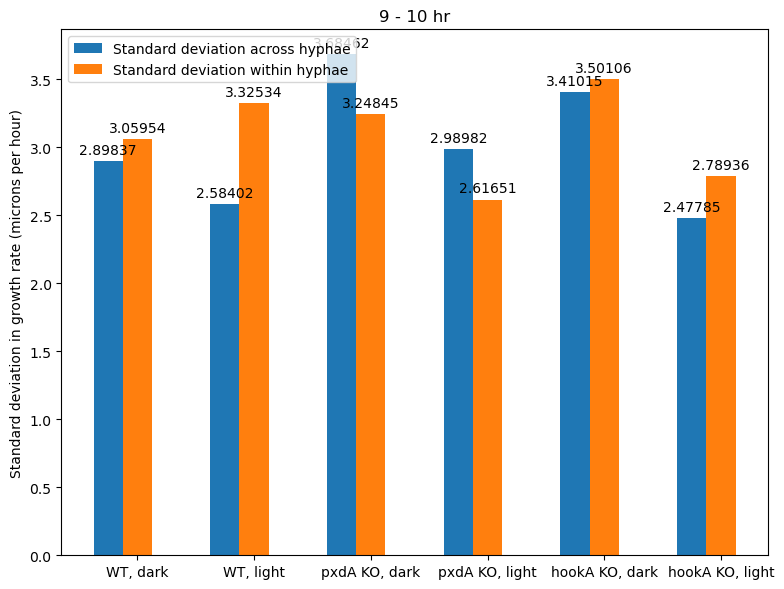

In [342]:
frame_clip = (36, 48)

intra_variation_dark_27, inter_variation_dark_27 = vel_std_dev(
    tracked_df_dark_27,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_dark_32, inter_variation_dark_32 = vel_std_dev(
    tracked_df_dark_32,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_dark_36, inter_variation_dark_36 = vel_std_dev(
    tracked_df_dark_36,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_light_27, inter_variation_light_27 = vel_std_dev(
    tracked_df_light_27,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_light_32, inter_variation_light_32 = vel_std_dev(
    tracked_df_light_32,
    mppYX,
    fph,
    frames=frame_clip,
)
intra_variation_light_36, inter_variation_light_36 = vel_std_dev(
    tracked_df_light_36,
    mppYX,
    fph,
    frames=frame_clip,
)

constructs = (
    "WT, dark",
    "WT, light",
    "pxdA KO, dark",
    "pxdA KO, light",
    "hookA KO, dark",
    "hookA KO, light",
)

variation = {
    "Standard deviation across hyphae": (
        inter_variation_dark_27,
        inter_variation_light_27,
        inter_variation_dark_32,
        inter_variation_light_32,
        inter_variation_dark_36,
        inter_variation_light_36,
    ),
    "Standard deviation within hyphae": (
        intra_variation_dark_27,
        intra_variation_light_27,
        intra_variation_dark_32,
        intra_variation_light_32,
        intra_variation_dark_36,
        intra_variation_light_36,
    ),
}

x = np.arange(6)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout="tight", figsize=(8, 6))  # layout="constrained"

for attribute, measurement in variation.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Standard deviation in growth rate (microns per hour)")
ax.set_title("9 - 10 hr")
ax.set_xticks(x + width, constructs)
ax.legend(loc="upper left", ncols=1)
# ax.set_ylim(0, 250)

plt.show()

#### Dependence of velocity on curvature

In [349]:
def add_curvature(tracked_df):
    tracked_dataframe = tracked_df.copy()
    # Sort by frame
    # tracked_dataframe = tracked_dataframe[
    #     (tracked_dataframe["frame"] >= frames[0])
    #     & (tracked_dataframe["frame"] < frames[1])
    # ]
    tracked_dataframe = tracked_dataframe.sort_values("frame")

    # List out tracks
    tracks = tracked_dataframe["particle"].unique()

    for track in tracks:
        angle_with_initial = tracked_dataframe.loc[
            tracked_dataframe["particle"] == track, "vel_angle_with_initial"
        ].values
        angular_deflection = angle_with_initial[1:] - angle_with_initial[:-1]
        angular_deflection = np.insert(angular_deflection, 0, 0)
        tracked_dataframe.loc[
            tracked_dataframe["particle"] == track, "angular_deflection"
        ] = angular_deflection

    return tracked_dataframe

In [351]:
curvature_df_dark_27 = add_curvature(tracked_df_dark_27)
curvature_df_dark_32 = add_curvature(tracked_df_dark_32)
curvature_df_dark_36 = add_curvature(tracked_df_dark_36)
curvature_df_light_27 = add_curvature(tracked_df_light_27)
curvature_df_light_32 = add_curvature(tracked_df_light_32)
curvature_df_light_36 = add_curvature(tracked_df_light_36)

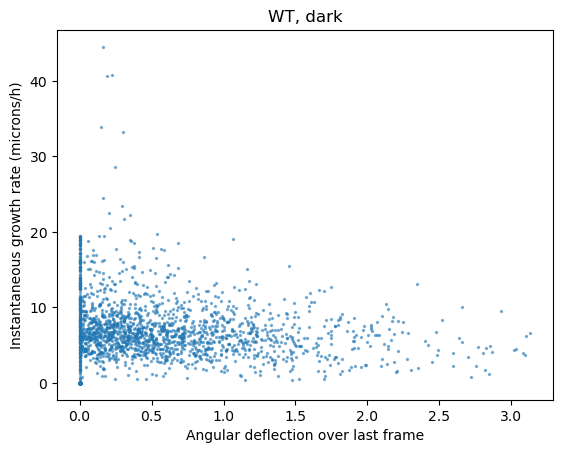

In [359]:
construct_df = curvature_df_dark_27

plt.scatter(
    np.abs(construct_df["angular_deflection"]),
    construct_df["v"] * mppYX * fph,
    s=2,
    alpha=0.5,
)
plt.xlabel("Angular deflection over last frame")
plt.ylabel("Instantaneous growth rate (microns/h)")

plt.title("WT, dark")

plt.show()

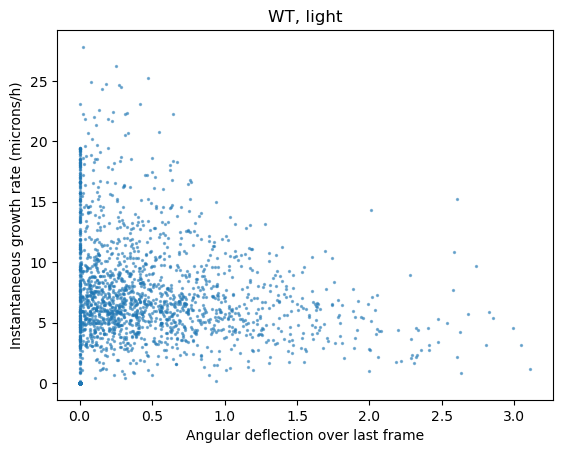

In [360]:
construct_df = curvature_df_light_27

plt.scatter(
    np.abs(construct_df["angular_deflection"]),
    construct_df["v"] * mppYX * fph,
    s=2,
    alpha=0.5,
)
plt.xlabel("Angular deflection over last frame")
plt.ylabel("Instantaneous growth rate (microns/h)")
plt.title("WT, light")

plt.show()

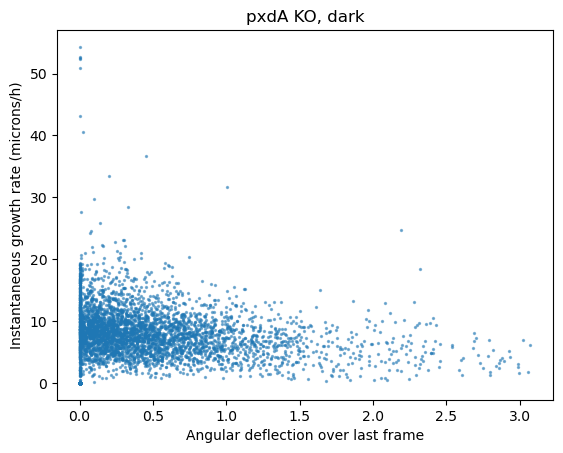

In [361]:
construct_df = curvature_df_dark_32

plt.scatter(
    np.abs(construct_df["angular_deflection"]),
    construct_df["v"] * mppYX * fph,
    s=2,
    alpha=0.5,
)
plt.xlabel("Angular deflection over last frame")
plt.ylabel("Instantaneous growth rate (microns/h)")
plt.title("pxdA KO, dark")

plt.show()

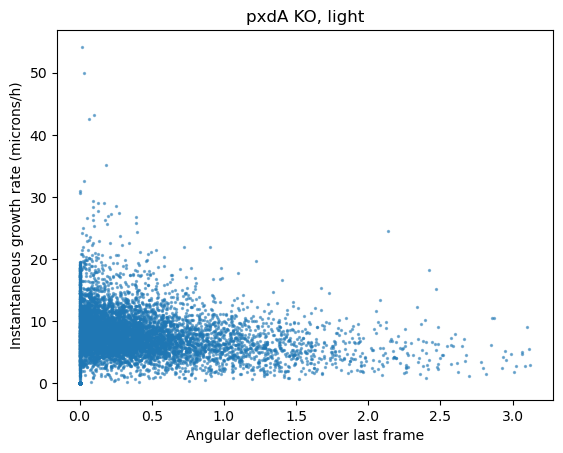

In [362]:
construct_df = curvature_df_light_32

plt.scatter(
    np.abs(construct_df["angular_deflection"]),
    construct_df["v"] * mppYX * fph,
    s=2,
    alpha=0.5,
)
plt.xlabel("Angular deflection over last frame")
plt.ylabel("Instantaneous growth rate (microns/h)")
plt.title("pxdA KO, light")

plt.show()

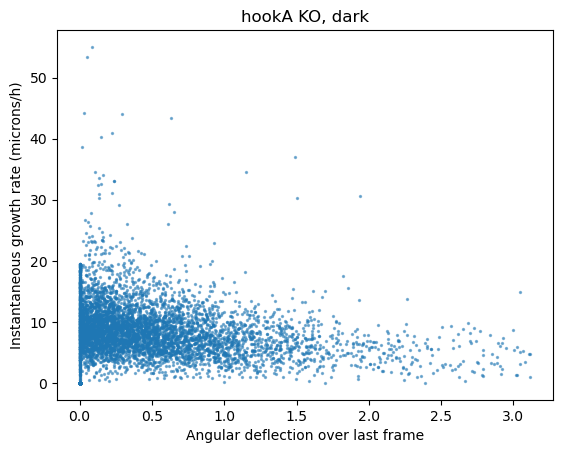

In [363]:
construct_df = curvature_df_dark_36

plt.scatter(
    np.abs(construct_df["angular_deflection"]),
    construct_df["v"] * mppYX * fph,
    s=2,
    alpha=0.5,
)
plt.xlabel("Angular deflection over last frame")
plt.ylabel("Instantaneous growth rate (microns/h)")
plt.title("hookA KO, dark")

plt.show()

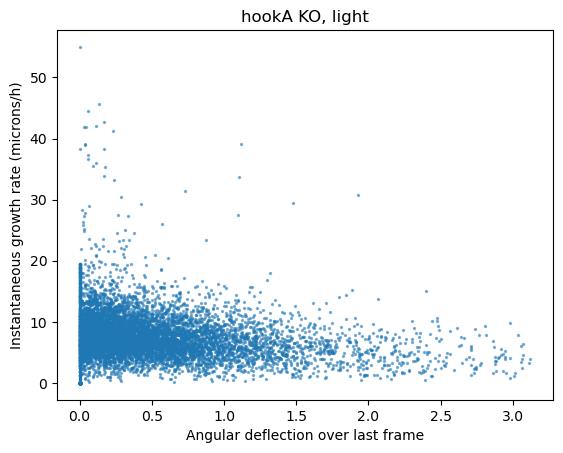

In [364]:
construct_df = curvature_df_light_36

plt.scatter(
    np.abs(construct_df["angular_deflection"]),
    construct_df["v"] * mppYX * fph,
    s=2,
    alpha=0.5,
)
plt.xlabel("Angular deflection over last frame")
plt.ylabel("Instantaneous growth rate (microns/h)")
plt.title("hookA KO, light")

plt.show()

#### Dependence of velocity and curvature on nearest-neighbor distance

In [370]:
def add_nn(tracked_df, mpp, pos_columns=["y", "x"]):
    tracked_dataframe = tracked_df.copy()

    def _nn_dist(row):
        # All frames before current point
        current_frame = row["frame"]
        current_position = row[pos_columns]
        subdf = tracked_dataframe[
            (tracked_dataframe["frame"] <= current_frame)
            & (tracked_dataframe["particle"] != row["particle"])
        ]

        # Distances to curent point
        distances = np.sqrt(
            np.nansum(((subdf[pos_columns] - current_position) ** 2), axis=1)
        )
        min_distance = np.min(distances) * mppYX

        return min_distance

    tracked_dataframe["dist_to_nn"] = tracked_dataframe.apply(_nn_dist, axis=1)

    return tracked_dataframe

In [372]:
nn_df_dark_27 = add_nn(curvature_df_dark_27, mppYX)
nn_df_dark_32 = add_nn(curvature_df_dark_32, mppYX)
nn_df_dark_36 = add_nn(curvature_df_dark_36, mppYX)
nn_df_light_27 = add_nn(curvature_df_light_27, mppYX)
nn_df_light_32 = add_nn(curvature_df_light_32, mppYX)
nn_df_light_36 = add_nn(curvature_df_light_36, mppYX)

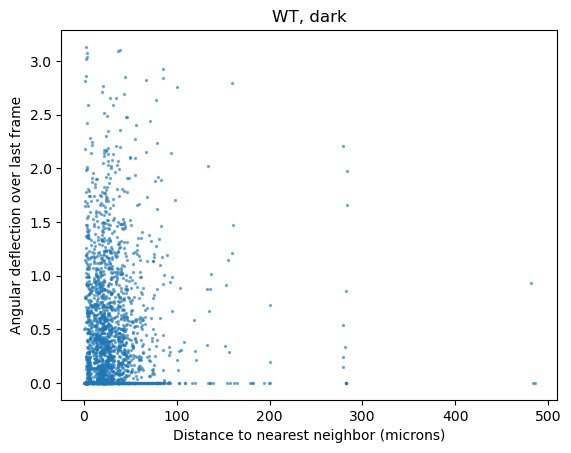

In [379]:
construct_df = nn_df_dark_27

plt.scatter(
    np.abs(construct_df["dist_to_nn"]),
    np.abs(construct_df["angular_deflection"]),
    s=2,
    alpha=0.5,
)
plt.ylabel("Angular deflection over last frame")
plt.xlabel("Distance to nearest neighbor (microns)")
plt.title("WT, dark")

plt.show()

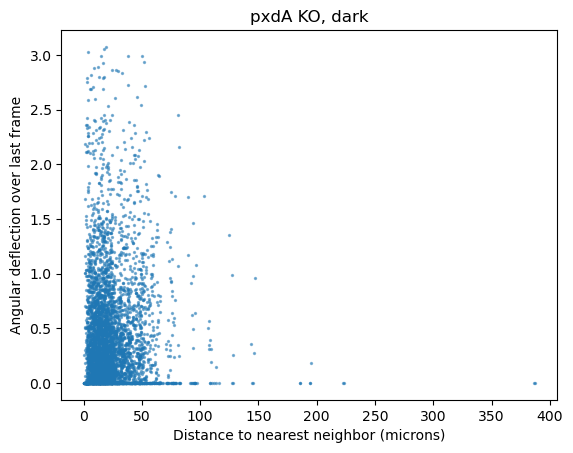

In [380]:
construct_df = nn_df_dark_32

plt.scatter(
    np.abs(construct_df["dist_to_nn"]),
    np.abs(construct_df["angular_deflection"]),
    s=2,
    alpha=0.5,
)
plt.ylabel("Angular deflection over last frame")
plt.xlabel("Distance to nearest neighbor (microns)")
plt.title("pxdA KO, dark")

plt.show()

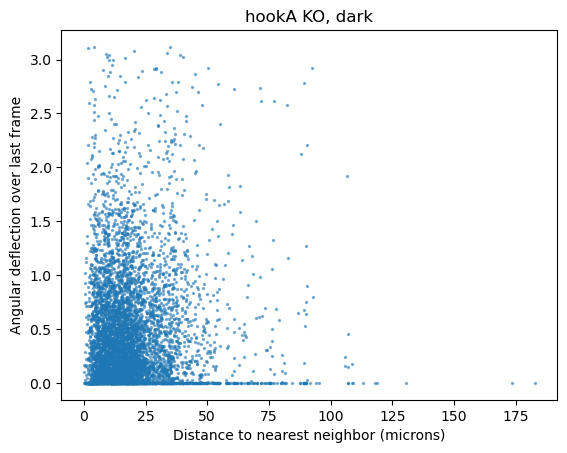

In [381]:
construct_df = nn_df_dark_36

plt.scatter(
    np.abs(construct_df["dist_to_nn"]),
    np.abs(construct_df["angular_deflection"]),
    s=2,
    alpha=0.5,
)
plt.ylabel("Angular deflection over last frame")
plt.xlabel("Distance to nearest neighbor (microns)")
plt.title("hookA KO, dark")

plt.show()

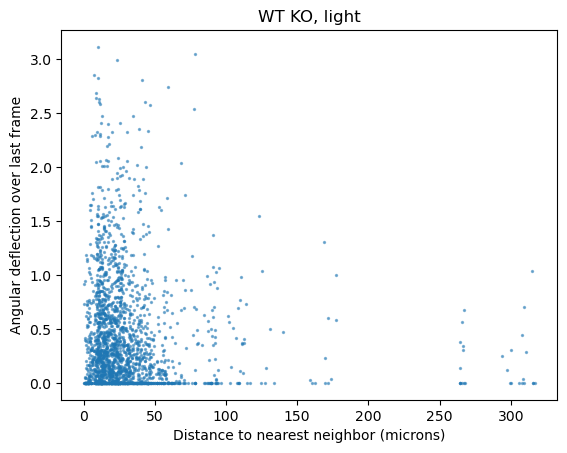

In [382]:
construct_df = nn_df_light_27

plt.scatter(
    np.abs(construct_df["dist_to_nn"]),
    np.abs(construct_df["angular_deflection"]),
    s=2,
    alpha=0.5,
)
plt.ylabel("Angular deflection over last frame")
plt.xlabel("Distance to nearest neighbor (microns)")
plt.title("WT KO, light")

plt.show()

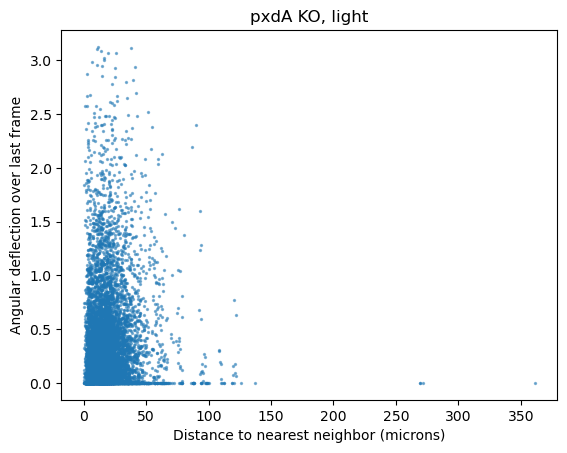

In [383]:
construct_df = nn_df_light_32

plt.scatter(
    np.abs(construct_df["dist_to_nn"]),
    np.abs(construct_df["angular_deflection"]),
    s=2,
    alpha=0.5,
)
plt.ylabel("Angular deflection over last frame")
plt.xlabel("Distance to nearest neighbor (microns)")
plt.title("pxdA KO, light")

plt.show()

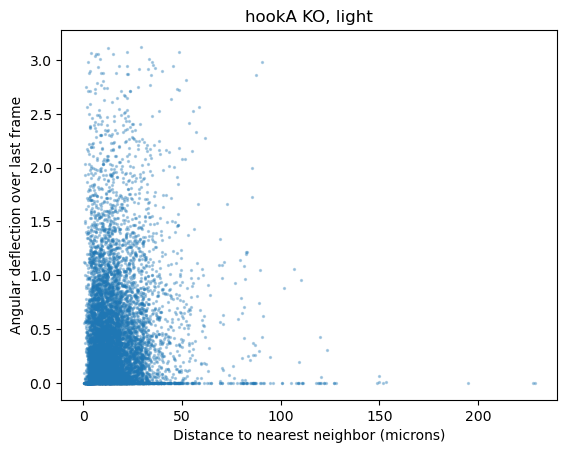

In [385]:
construct_df = nn_df_light_36

plt.scatter(
    np.abs(construct_df["dist_to_nn"]),
    np.abs(construct_df["angular_deflection"]),
    s=2,
    alpha=0.3,
)
plt.ylabel("Angular deflection over last frame")
plt.xlabel("Distance to nearest neighbor (microns)")
plt.title("hookA KO, light")

plt.show()